# Development & Discovery Notebook, FixMatchSeg
In this notebook we document the process of working with the platform and zod to create FixMatchSeg. This notebook is not intended to be run as a script, but rather to be used as a reference for how to use the platform and zod.

## Initialise the platform and zod

In [2]:
from fedswarm import Platform

# basic config without any learning
config = {
    "data":{
        "path": "/mnt/ZOD",
        "version":"full",
        "ratio":1,
        "img_size": [400, 1420],
        "transforms": "",
        "shuffle_seed": 101,
        "decentralised_shuffle_seed": 101,
        "dataloader_args": {
            "batch_size": 32,
            "pin_memory": True,
            "shuffle": True,
        },
        "train_val_id_generator":"balanced_frames_borrowed",
        "dataset_getitem":"ego_road_segmentation",
    },
    "model":{
        "name": "fixmatchseg",
        "args": {},
        "loss":"L1Loss",
        "optimiser":"Adam",
        "optimiser_args":{
            "lr": 0.0001,
        }
    }
}

platform = Platform(config, data_only=True, write=False)

No same run found, creating new run


Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

In [3]:
# plotting settings
import matplotlib.pyplot as plt
import scienceplots
from tbparse import SummaryReader

plt.style.use('science')
plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams.update({'font.size': 8})

Get some relevant training ids and the `zod_frames` object

In [4]:
# some global variables that we will use later
train_ids = platform.data.train._ids
zod_frames = platform.data.zod_frames

## Visualise the data

We will visualise the data using some ZOD features.

GetItem: [idx: 0, 015797]
GetItem: [idx: 0, 015797] ImageType <class 'numpy.ndarray'>, LabelType <class 'list'>, LabelLen 15


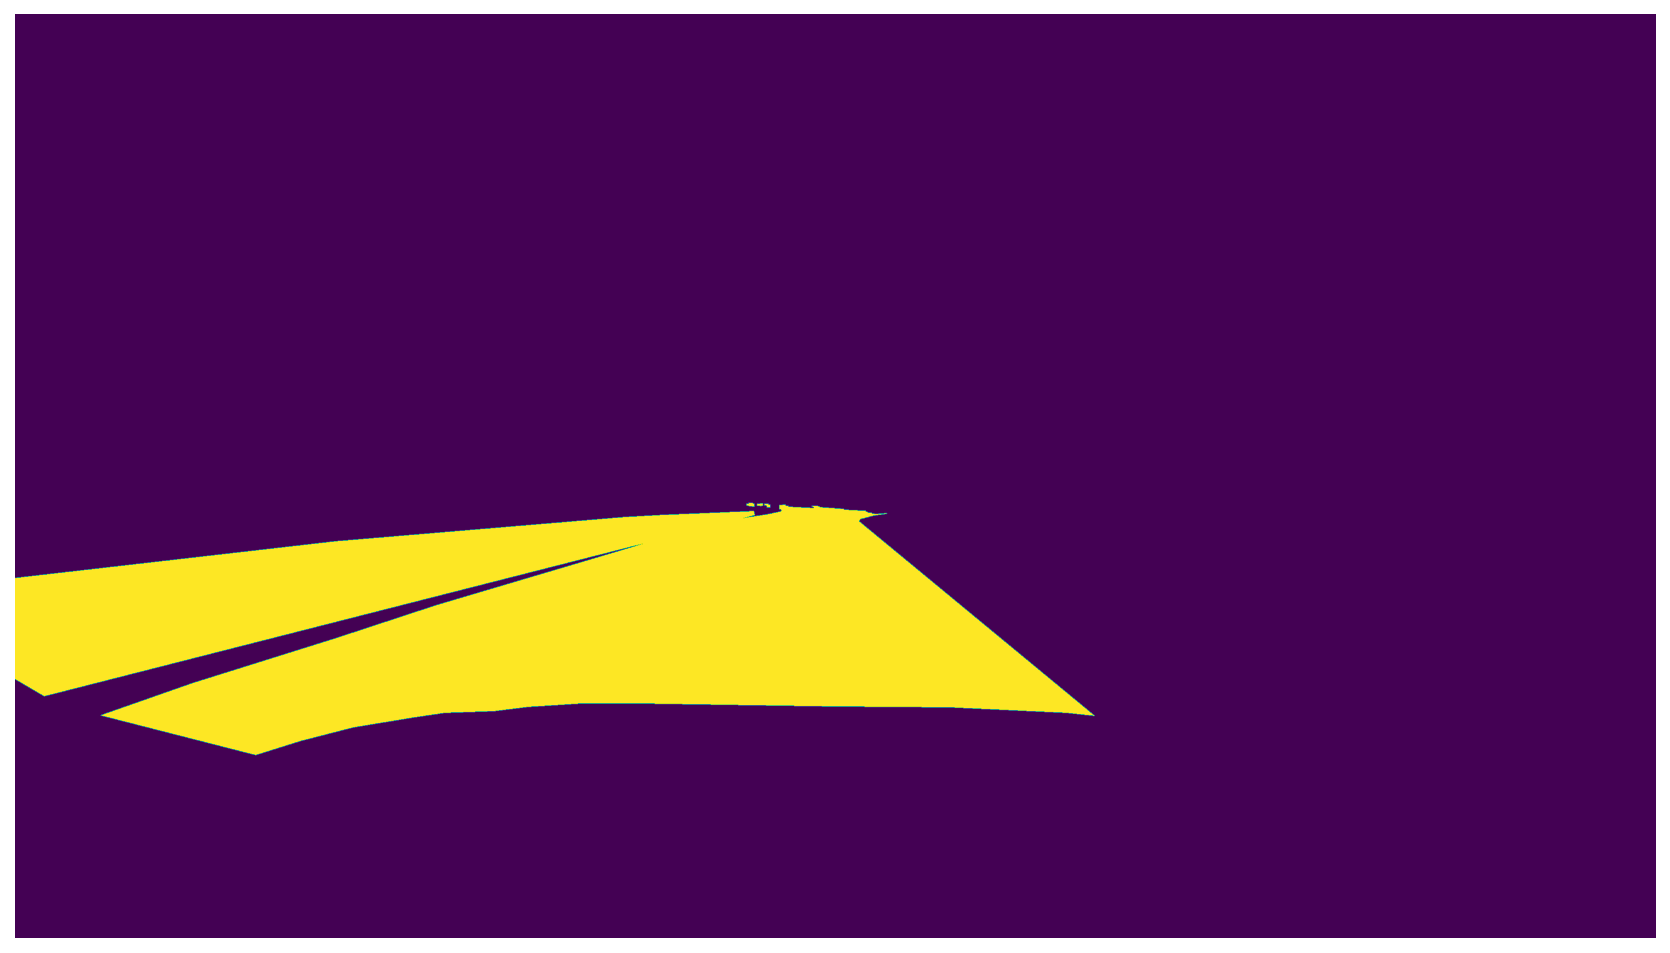

In [5]:
# fetch 
image, annotation = platform.data.train.dataset[0]
image = image.numpy()

from zod.utils.polygon_transformations import polygons_to_binary_mask
# convert the polygons to a binary mask (which can be used
# for ground truth in e.g. semantic segmentation)
mask = polygons_to_binary_mask(annotation)

import matplotlib.pyplot as plt
# visualize the mask
plt.axis("off")
plt.imshow(mask)
plt.show()

Overlaying the mask on the image

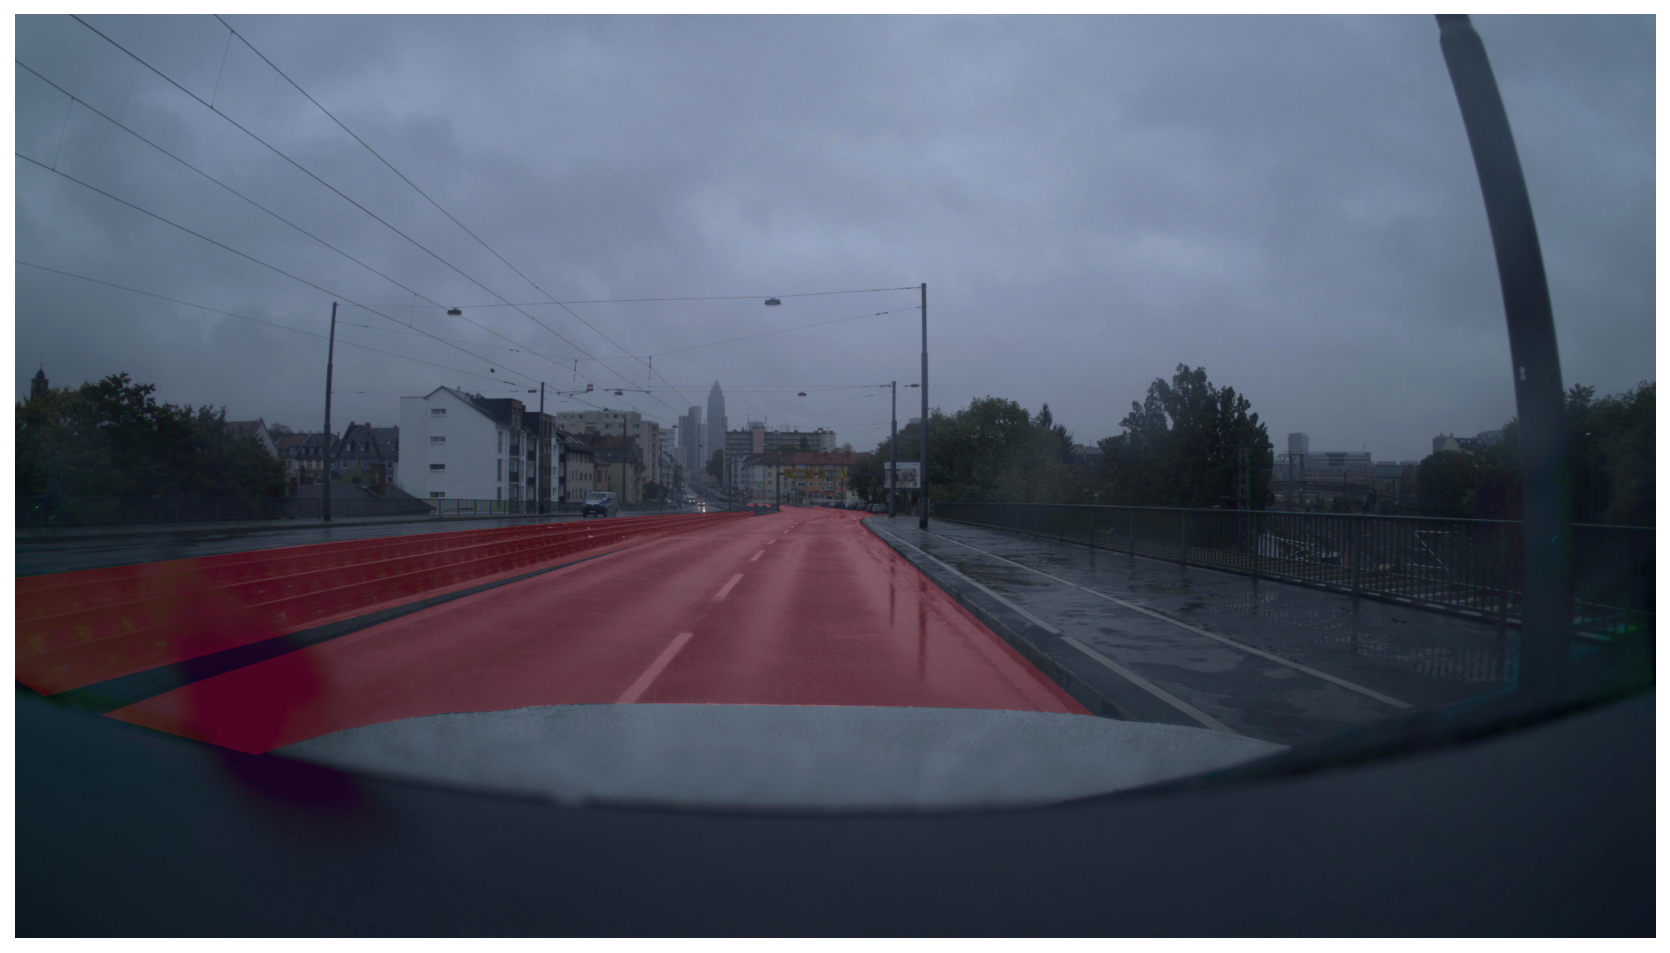

In [6]:
from zod.visualization.polygon_utils import overlay_mask_on_image

# overlay the mask on the image
to_plottable = lambda image: ((image - image.min()) / (image.max() - image.min()) * 255).astype("uint8").transpose(1, 2, 0)

rendered_image = overlay_mask_on_image(mask, to_plottable(image), fill_color=(100, 0, 0), alpha=0.5)

# visualize the mask
plt.axis("off")
plt.imshow(rendered_image)
plt.show()

## Reconstructing the training loop

__Loss__ <br>
Excerpt from the paper:
> For semantic segmentation loss, we used the widely used soft dice loss DL defined on [27] combined with boundary loss BL explained in [28]. In this study, both dice loss and boundary loss have equal contributions in the final loss calculation.

__Architecture diagram__

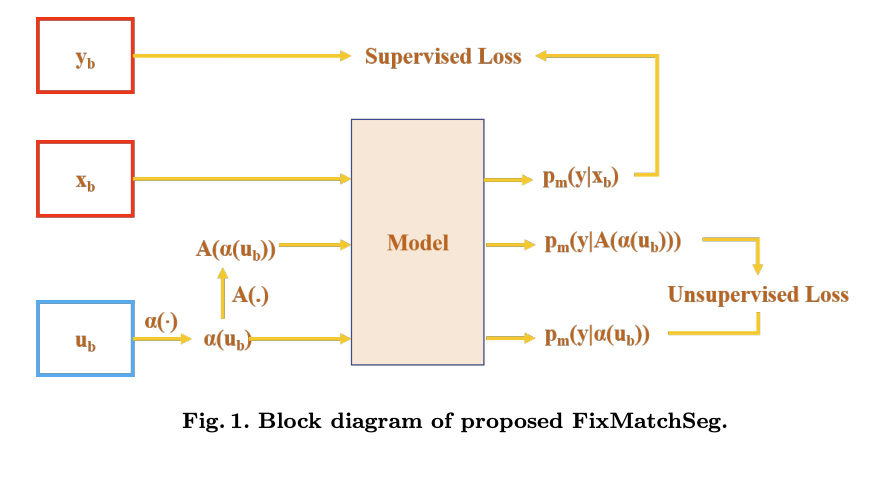

In [24]:
from zod.constants import AnnotationProject
ego_road_id_set = dict()
for id_set, name in zip([platform.data.train._ids, platform.data.val._ids], ["train", "val"]):
    ego_road_id_set[name] = set()
    with_ego_road = ego_road_id_set[name]
    for id in platform.data.train._ids:
        if len(zod_frames[id].info.annotation_frames.get(AnnotationProject.EGO_ROAD)) > 0:
            with_ego_road.add(id)
    ego_road_id_set[name] = list(ego_road_id_set[name])

In [25]:
# calculate losses
import torch
import numpy as np

criterion  = torch.nn.BCELoss()

ego_road_id_set_valid = dict()
ego_road_id_set_faulty = dict()

for set_name, ids in ego_road_id_set.items():
    ego_road_id_set_valid[set_name] = set()
    ego_road_id_set_faulty[set_name] = set()
    for id in ids:
        try:
            binary_mask = torch.tensor(polygons_to_binary_mask(platform.data.zod_frames[id].get_annotation(AnnotationProject.EGO_ROAD))).float()
            criterion(binary_mask, binary_mask)
            ego_road_id_set_valid[set_name].add(id)
        except Exception as e:
            ego_road_id_set_faulty[set_name].add(id)
            continue
    ego_road_id_set_valid[set_name] = list(ego_road_id_set_valid[set_name])
    ego_road_id_set_faulty[set_name] = list(ego_road_id_set_faulty[set_name])

/home/alex/miniconda3/envs/swarm/lib/python3.10/site-packages/zod/utils/polygon_transformations.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  poly_array = np.array(polygon).reshape((-1, 1, 2)).astype(np.int32)


In [27]:
# save dict to file
import json

with open("ego_road_id_set_valid.json", "w") as f:
    json.dump(ego_road_id_set_valid, f)
with open("ego_road_id_set_faulty.json", "w") as f:
    json.dump(ego_road_id_set_faulty, f)

We have already defined what the model is like in a custom model file. So we can import it using the platform

In [ ]:
from fedswarm.utils.models.model_manager import load_model_from_name

# load the FixMatchSeg model
model = load_model_from_name(config["model"]["name"], **config["model"]["args"]).cuda()

We will first find a relevant image size for the model. We will play with the transforms to find a good configuration.

Dataloader not created explicitly, creating it, do not forget to unmount it!


GetItem: [idx: 0, 015797]
GetItem: [idx: 0, 015797] ImageType <class 'numpy.ndarray'>, LabelType <class 'list'>, LabelLen 15


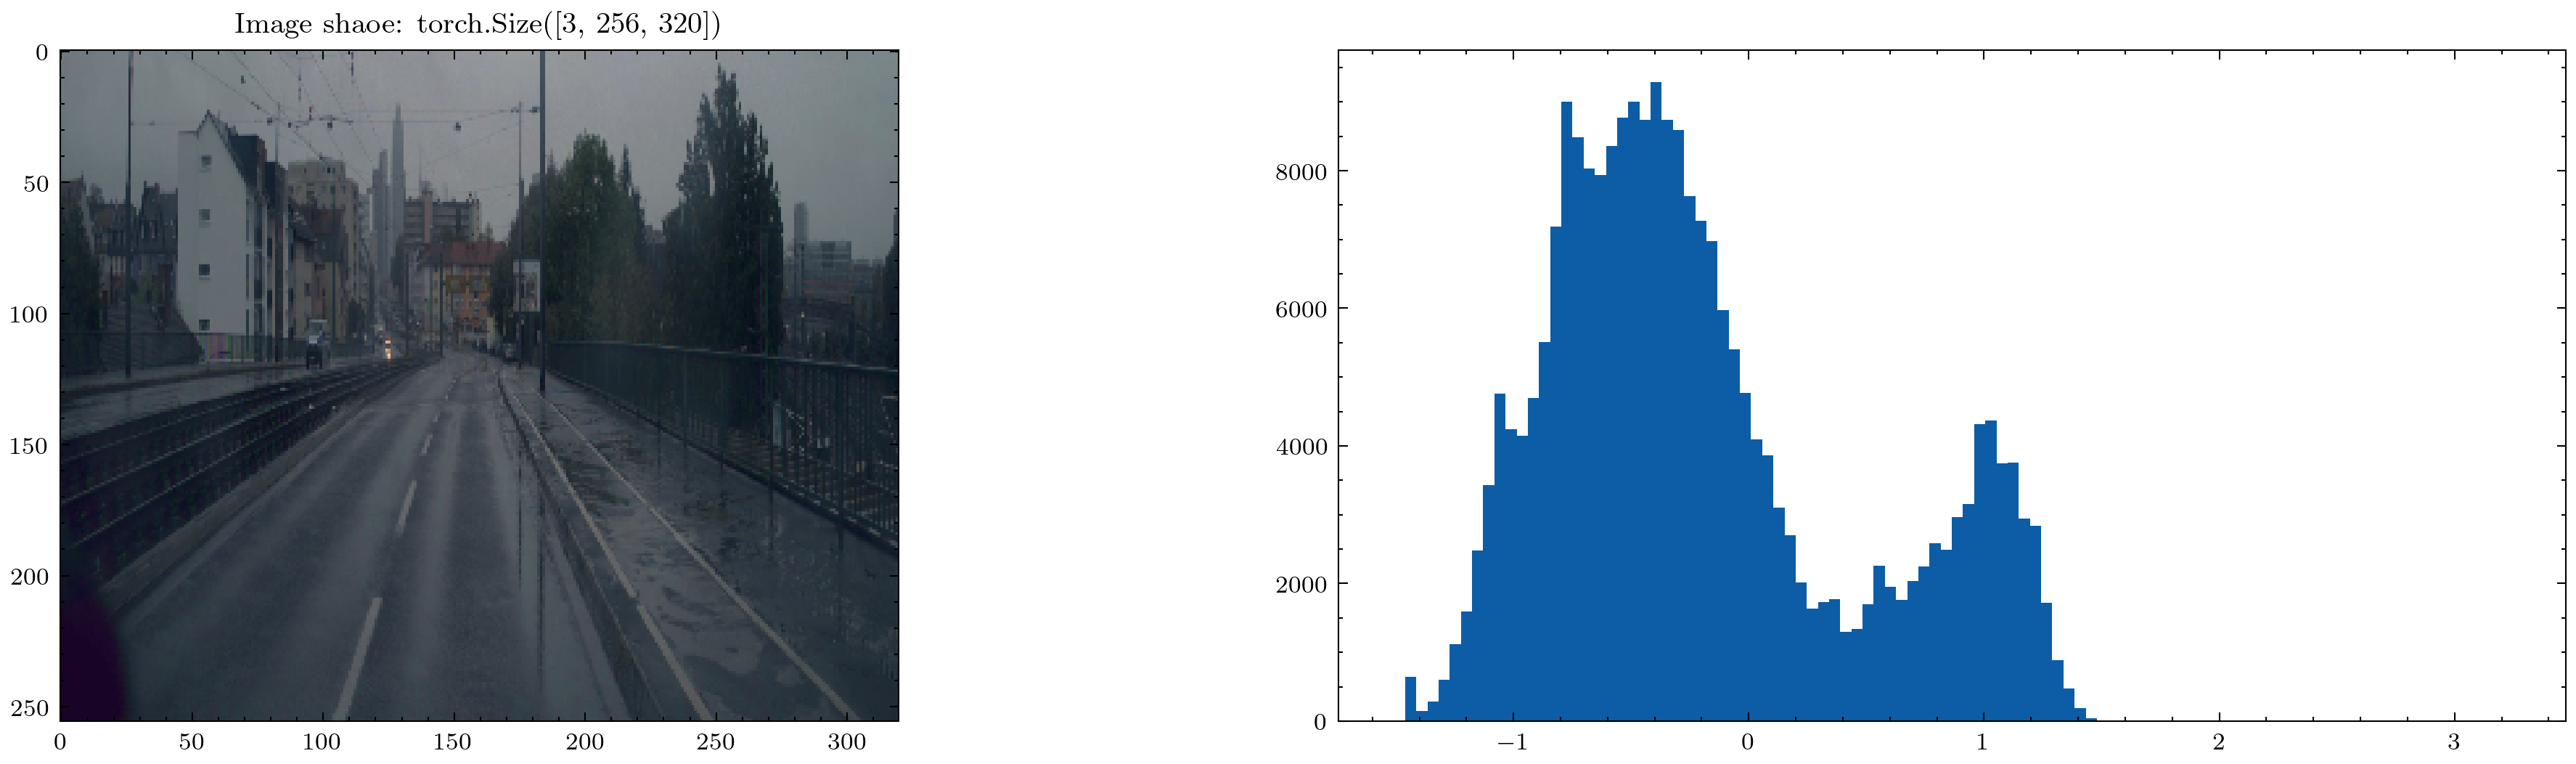

Layer (type:depth-idx)                                       Output Shape              Param #
FixMatchSeg                                                  [32, 2, 256, 320]         --
├─Unet: 1-1                                                  [32, 2, 256, 320]         --
│    └─EfficientNetEncoder: 2-1                              [32, 3, 256, 320]         806,400
│    │    └─Conv2dStaticSamePadding: 3-1                     [32, 48, 128, 160]        1,296
│    │    └─BatchNorm2d: 3-2                                 [32, 48, 128, 160]        96
│    │    └─MemoryEfficientSwish: 3-3                        [32, 48, 128, 160]        --
│    │    └─ModuleList: 3-4                                  --                        16,740,824
│    └─UnetDecoder: 2-2                                      [32, 16, 256, 320]        --
│    │    └─Identity: 3-5                                    [32, 448, 8, 10]          --
│    │    └─ModuleList: 3-6                                  --                

In [ ]:
from torchinfo import summary
from torchvision.transforms import *
from fedswarm.utils.data.extensions.custom_transforms import CustomCrop

# change the transforms
platform.data.train.dataloader.dataset.transforms.transforms = [
    ToTensor(), 
    CustomCrop(800, 500, 800, 2840), 
    Resize((256, 320)), 
    Normalize(mean=[0.337, 0.345, 0.367], std=[0.160, 0.180, 0.214]),
]

# fetch a transformed image from the dataset
sample = platform.data.train.dataloader.dataset[0][0]
rendered_image = to_plottable(sample.numpy())

plt.subplot(1, 2, 1)
plt.title("Image shaoe: {}".format(sample.shape))
plt.imshow(rendered_image)
plt.subplot(1, 2, 2)
plt.hist(sample.flatten().numpy(), bins=100)
plt.show()
summary(model, (platform.data.train.dataloader.batch_size, *sample.shape))

We should note that:
> Unlike classification tasks, in semantic segmentation,
the output target is not invariant under geometric transformations such as flips,
affine or elastic distortions that change the shape or location of objects in the image.

In [ ]:
import torch

device = next(model.parameters()).device

images, labels = next(iter(platform.data.train.dataloader))
images, labels = images.to(device), labels.to(device)

# predict
labeled_prediction = model(images)
weak_prediction = model(None)
strong_prediction = model(None)

# calculate losses
criterion  = torch.nn.BCELoss()

loss_supervised = criterion(labeled_prediction, labels)

# create psuedo labels
psuedo_labels = None

if psuedo_labels:
    loss_unsupervised = criterion(strong_prediction, psuedo_labels)

GetItem: [idx: 63339, 076083]


ValueError: min() arg is an empty sequence

In [ ]:
import torch
import torch.nn.functional as F

# Assumptions:
# - model: A trained semantic segmentation model
# - train_dataloader: A dataloader with both labeled and unlabeled data
# - optimizer: An optimizer for the model
# - num_epochs: Number of epochs to train
# - device: The device (GPU or CPU) to train the model on
# - tau: Confidence threshold
# - lambda_u: Weight for the unsupervised loss

# Placeholder functions:
# - weak_augmentation(image): Applies weak augmentation to the input image
# - strong_augmentation(image): Applies strong augmentation to the input image
# - to_device(data, device): Moves data to the specified device

def train_fixmatchseg(model, train_dataloader, optimizer, num_epochs, device, tau, lambda_u):
    model = model.to(device)
    
    for epoch in range(num_epochs):
        for labeled_batch, unlabeled_batch in train_dataloader:
            xb, pb = labeled_batch
            ub = unlabeled_batch

            # Move data to device
            xb, pb = to_device((xb, pb), device)
            ub = ub.to(device)

            # Apply weak and strong augmentations
            xb_weak = weak_augmentation(xb)
            ub_weak = weak_augmentation(ub)
            ub_strong = strong_augmentation(ub_weak)

            # Calculate supervised loss
            pb_pred = model(xb_weak)
            ls = F.cross_entropy(pb_pred, pb)

            # Calculate unsupervised loss
            with torch.no_grad():
                qb_pred = model(ub_weak)
                qb = qb_pred.max(dim=1)[0]  # pixel-wise max
                qb_mean = qb.mean()         # average confidence score
                qb_argmax = qb_pred.argmax(dim=1)  # pixel-wise argmax

            mask = (qb_mean >= tau).float()
            lu = F.cross_entropy(model(ub_strong), qb_argmax) * mask

            # Calculate total loss
            loss = ls + lambda_u * lu

            # Update the model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Log epoch information
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

